<a href="https://colab.research.google.com/github/DenisseDB/MachineLearning-BankAnalyses/blob/main/BankSell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight
%matplotlib inline

# If you would like to make further imports from Tensorflow, add them here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Data Balancing
from collections import Counter
from imblearn.over_sampling import KMeansSMOTE

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# /content/drive/MyDrive/BankData/bank-full.csv
%cd "/content/drive/MyDrive/BankData"

/content/drive/MyDrive/BankData


In [48]:
tf.random.set_seed(42)
np.random.seed(42)

**OBTENER EL DATASET**

Cargar mi dataset y dividirlo para lo que usaremos para el test y el train

In [49]:
df = pd.read_csv("bank-full.csv", delimiter=";")

*Limpiar los datos*

Seleccionar columnas que usaremos para el modelo


In [50]:
columnas = ['age', 'marital', 'education', 'default', 'loan', 'duration', 'y']
df_columnas_seleccionadas = df[columnas]

In [51]:
df_columnas_seleccionadas = df_columnas_seleccionadas[df_columnas_seleccionadas['education'] != 'unknown']
df_columnas_seleccionadas.reset_index(drop=True, inplace=True)

**SEPARACIÓN DEL SET DE PRUEBA Y DEL SET DE TRAINING**

Ya que lo limpiamos, ahora si dividimos el data set para tener el conjunto que sera entrenado y el conjunto que sera para pruebas (train_data y test_data)

In [52]:
test_data = df_columnas_seleccionadas.iloc[:21677]
train_data = df_columnas_seleccionadas.iloc[21677:]

Como queremos estudiar si contrataran o no la tarjeta, y ese dato viene en la columna Y, debemos quitar esa información de nuestros fragmentos de datos

In [53]:
test_labels_target = test_data["y"]
test_data = test_data.drop(columns=["y"])
train_labels_target = train_data["y"]
train_data = train_data.drop(columns=["y"])
## modelo de entrenamiento
## punto fit paso matrix de las x y de las Y

**PREPROCESADO DEL TARGET**
*Label Encoder*

Como el modelo solo acepta números, debemos pasar mi target a binario, para eso usaremos Label encoder, ya que:

*   Solo tenemos dos categorias (yes / no)
*   Al tener solo dos categorias, no hay problema confusión de orde
*   Usa menos memoria



In [54]:
enc = LabelEncoder()
train_labels_target = enc.fit_transform(train_labels_target)
test_labels_target = enc.transform(test_labels_target)

**PREPROCESADO DE FEATURES**

Usamos OneHotEncoder ya que tenemos mas de dos categorias, nos guiamos con "Titanic Solution One-Hot-Encode All The Things"

In [55]:
# Apply one-hot encoder to each column with categorical data
object_cols = train_data.select_dtypes(include='object').columns
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_encoder.fit(train_data[object_cols])
OH_cols_train = pd.DataFrame(OH_encoder.transform(train_data[object_cols]))
joblib.dump(OH_encoder, '/content/drive/MyDrive/BankData/onehotencoder.pkl')
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_data[object_cols]))

OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

# One-hot encoding removed index; put it back
OH_cols_train.index = train_data.index
OH_cols_test.index = test_data.index

# Add one-hot encoded columns to numerical features (age - duration)
numeric_columns = train_data.drop(columns=object_cols).columns
numeric_train = train_data[numeric_columns]
numeric_test = test_data[numeric_columns]

train_data = pd.concat([OH_cols_train, numeric_train], axis=1)
test_data = pd.concat([OH_cols_test, numeric_test], axis=1)

**Construir el modelo**

In [56]:
def get_model_simple(input_shape):
    model  =  Sequential([
                    Flatten(input_shape=input_shape),
                    # las capas del modelo
                    Dense(128, activation='relu'),
                    Dense(128, activation='relu'),
                    # solo necesitamos una neurona de salida cuando trabajamos con binario
                    Dense(1, activation='sigmoid')
    ])
    return model

In [57]:
# pasamos los hiperparametros y configurar la red
def compile_model_simple(model):
    # loss = diferencia entre las predicciones de un modelo
    model.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['accuracy',
                                                                            tf.keras.metrics.Precision(name="precision"),
                                                                            tf.keras.metrics.Precision(name="recall"),
                                                                           ])



* train_data son los datos que usaremos para el entrenamiento
* train_labels_target para que voy a entrenar mis train_data
* epochs las epocas para saber cuantas veces le voy a dar la vuelta



In [58]:
def train_model_simple(model, train_data, train_labels_target):
    history = model.fit(train_data, train_labels_target, epochs = 100, class_weight = class_weights)
    return history

**BALANCEO DE DATOS USANDO K-MEANS SMOTE**

In [59]:
print(f"The number of classes before fit: {Counter(train_labels_target)}")
kms = KMeansSMOTE(random_state=42)
train_data, train_labels_target = kms.fit_resample(train_data, train_labels_target)
print(f"The number of classes after fit: {Counter(train_labels_target)}")

The number of classes before fit: Counter({np.int64(0): 17693, np.int64(1): 3984})
The number of classes after fit: Counter({np.int64(1): 17694, np.int64(0): 17693})


Evitemos que el modelo ignore a la clase minoritaria, decirle al modelo, cuando le va a doler equivocarse


In [60]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_target), y=train_labels_target)
class_weights = dict(enumerate(weights))

* Obtenemos el modelo, entre mas parametros es mas poderoso el modelo, sin embargo, será mas pesado
* Con summary vemos el modelo completo para despues compilarlo
* Hacemos el entrenamiento

In [61]:
model_nn = get_model_simple(input_shape=train_data.shape[1:])
model_nn.summary()
compile_model_simple(model_nn)
history_nn = train_model_simple(model_nn, train_data, train_labels_target)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,305 (71.50 KB)

 Trainable params: 18,305 (71.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8178 - loss: 0.9604 - precision: 0.8180 - recall: 0.8180
Epoch 2/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8641 - loss: 0.4751 - precision: 0.8887 - recall: 0.8887
Epoch 3/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8704 - loss: 0.3880 - precision: 0.8974 - recall: 0.8974
Epoch 4/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8754 - loss: 0.3568 - precision: 0.9051 - recall: 0.9051
Epoch 5/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8828 - loss: 0.3200 - precision: 0.9161 - recall: 0.9161
Epoch 6/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8836 - loss: 0.3095 - precision: 0.9194 - recall: 0.9194
Epoch 7/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8872 - loss: 0.3000 - precision: 0.9255 - recall: 0.9255
Epoch 8/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8882 - loss: 0.2935 - precision: 0.9253 - recall:

**MATRIZ DE CONFUSION**


678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


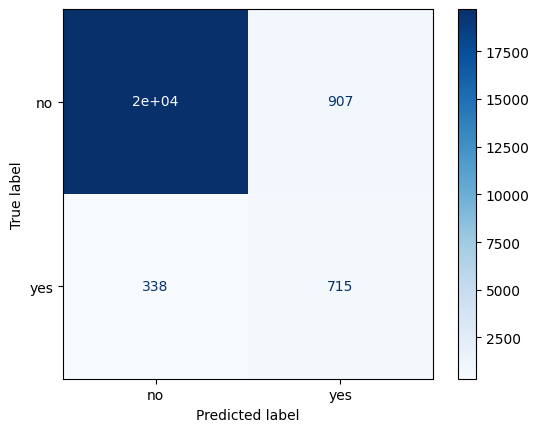

In [62]:
predictions_probabilities = model_nn.predict(test_data)
predictions = (predictions_probabilities > 0.5).astype(int)
predictions = predictions.flatten()

cm = confusion_matrix(test_labels_target, predictions)
labels = enc.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

De la prediccion:
Precision: Cuantos eran realmente positivos
Racall: De los TP, cuantos detecto el modelo
F1 Score: Media entre Precision y Recall (para datos desbalanceados)
Support: Cuantos yes y no había

Resumen: conocer si el modelo que tiene datos desbalanceados, realmente esta detectando de manera correcta la clase menos frecuente (yes)

In [63]:
print(classification_report(test_labels_target, predictions, target_names=labels))

              precision    recall  f1-score   support

          no       0.98      0.96      0.97     20624
         yes       0.44      0.68      0.53      1053

    accuracy                           0.94     21677
   macro avg       0.71      0.82      0.75     21677
weighted avg       0.96      0.94      0.95     21677



In [64]:
print(test_data.head())
print(test_data.tail())

   marital_divorced  marital_married  marital_single  education_primary  \
0               0.0              1.0             0.0                0.0   
1               0.0              0.0             1.0                0.0   
2               0.0              1.0             0.0                0.0   
3               0.0              1.0             0.0                0.0   
4               0.0              0.0             1.0                0.0   

   education_secondary  education_tertiary  default_no  default_yes  loan_no  \
0                  0.0                 1.0         1.0          0.0      1.0   
1                  1.0                 0.0         1.0          0.0      1.0   
2                  1.0                 0.0         1.0          0.0      0.0   
3                  0.0                 1.0         1.0          0.0      1.0   
4                  0.0                 1.0         1.0          0.0      0.0   

   loan_yes  age  duration  
0       0.0   58       261  
1       0.

**Matriz de confusion a mano**


[[  715   907]
 [  338 19717]]


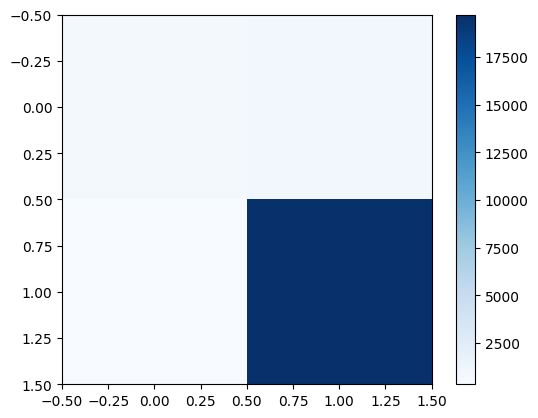

In [65]:
TP = 0
FP = 0
FN = 0
TN = 0

for i in range(len(predictions)):
    if predictions[i] == 1 and test_labels_target[i] == 1:
      TP += 1
    elif predictions[i] == 1 and test_labels_target[i] == 0:
      FP += 1
    elif predictions[i] == 0 and test_labels_target[i] == 1:
      FN += 1
    else:
      TN += 1

confusion_matrix = np.array([[TP, FP], [FN, TN]])
print(confusion_matrix)

plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.show()

**GUARDAR MODELO**

In [66]:
model_nn.save("banksell.keras")